# Simple Neural Network from Scratch
### Tomer Eldor
#### TT Deep Learning 1 
#### Oct 2018

## Import Libraries and Data

In [321]:
# Import Libraries and Data
import numpy as np
from sklearn.datasets import fetch_mldata # for importing the dataset only
import matplotlib.pyplot as plt # for plotting cost

dataset = fetch_mldata('MNIST original')
X_full, y_full = dataset['data'], dataset['target']

/Users/tomer/miniconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/Users/tomer/miniconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


## Preprocess Data

In [325]:
### PREPROCESS DATA ###
n_classes = 10

# Reduce to a susbsample (while working on the code)
SUBSAMPLE_SIZE = 10000 # choose how many samples for now
subsample_idx = np.random.choice(X_full.shape[0], SUBSAMPLE_SIZE) # array of indices of subsample
X, y = X_raw_full[subsample_idx], y_full[subsample_idx]

# Shuffle X and Y for random sampling
index_random = np.random.permutation(X.shape[0])
X, y = X[index_random], y[index_random]
n_train_samples = int(0.75*SUBSAMPLE_SIZE)


# Preprocess inputs and outputs
def preprocess_bw_image(x):
    '''Normalizes pixel values to be between 0 and 1 instead of 0–255'''
    return x/255.0
X_processed = preprocess_bw_image(X)

def onehot(y, n_classes):
    '''Reshapes y to a one-hot coding and flips the matrix shape to fit later calculations'''
    return np.eye(n_classes)[y.astype('int')] 
y_onehot = onehot(y, n_classes) # convert y to one-hot encoding, to compare with y_pred (for loss function)

# Divide into Training and Test Samples and Flip matrices for later computations
X_train, X_test = X_processed[:n_train_samples].T, X_processed[n_train_samples:].T
Y_train, Y_test = y_onehot[:n_train_samples].T, y_onehot[n_train_samples:].T

# Build Neural Network Class

In [328]:
# NEURAL NETWORK MLP CLASS

class neural_net_mlp:
    
    def __init__(self, X, Y, n_hidden_nodes = 15, n_classes = 10, learning_rate = 0.5):
        # initializing self NN parameters
        self.X = X
        self.Y = Y
        self.n_hidden_nodes = n_hidden_nodes
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.n_X_nodes = X.shape[0] # length of features/pixels of each observation
        # Initialize Weights and Biases
        self.Weights1 = np.random.normal(0, 1, size=(self.n_hidden_nodes, self.n_X_nodes))
        self.biases1 = np.random.normal(0, 1, size=(self.n_hidden_nodes, 1))
        self.Weights2 = np.random.normal(0, 1, size=(self.n_classes, self.n_hidden_nodes))
        self.biases2 = np.random.normal(0, 1, size=(self.n_classes, 1))
    
    
    ## Helper Math Functions
    
    def loss_function(self, y_true, y_pred):
        loss = np.sum(np.multiply(y_true, np.log(y_pred)))
        return -(1/y_true.shape[0]) * loss

    def sigmoid(self, x):
        return (1 / (1 + np.exp(-x)))
    
    def sigmoid_derivative(self, Z):
        sig = sigmoid(Z)
        return sig * (1 - sig)

    def softmax(self, x):
        ''' Softmax activation function. Applies softmax to the input x.
        (Its advantage is that it returns a vector of probabilities that sum up to 1)
        Arguments:
            - x: any vector
        Returns:
            - softmax(x) - vector of the same shape'''
        exps_x = np.exp(x)
        return exps_x / np.sum(exps_x, axis=0) 

    
    ## Nerual Network functions
    
    def fc_layer(self, inputs, weights, biases):
        '''
        Fully Connected Layer of MLP/NN: y = wx + b (weights*input + biases), 
        that fed into the activation function, so that y = activation(wx+b)
        Arguments:
             - inputs: input data for the layer - either the initial input for the net
                        or the ouput of the previous (lower) layer (np array of floats)
             - weights: set of weights for that layer's connections (np array of floats)
             - biases: set of biases for that layer's connections (np array of floats)
        Returns:
            Z: the result of the matrix multiplication of weights with previous layer's activations
        '''
        return np.matmul(weights, inputs) + biases

    def feed_forward(self, X):
        '''
        Constructs the NNet with 1 hidden layer and 1 output layer
        Feeds forward from the initial (preprocessed) input through those layers, generates prediction
        Arguments:
            - X: the input data for the network (numpy array of floats). size: (n_pixles (or features), n_observations)
            - Weights1 - initial values for weights of the first layer. np array of size: (n_hidden_nodes, n_initial_input_nodes)
            - biases1 - initial values for biases. vector of length: n_hidden_nodes
            - Weights2 - initial values for weights of the first layer. np array of size: (n_output_nodes, n_hidden_nodes)
            - biases2 - initial values for biases. vector of length: n_output_nodes
        Returns:
            - y_pred - prediction probability for each observation for each class
            - Z1: result of the fully connecter layer 1 (y=wx+b, before activation), needed for later gradient/derivatives
            - A1: result of Z1 after the activation function, needed for backpropagation later
        '''
        # FEED-FORWARD 
        # layer 0 - input layer
        self.A0 = self.sigmoid(X)
        # layer 1 - hidden layer
        Z1 = self.fc_layer(self.A0, self.Weights1, self.biases1)
        A1 = self.sigmoid(Z1)
        # layer 2 - output layer
        Z2 = self.fc_layer(A1, self.Weights2, self.biases2)
        # for the last layer, we'll yse softmax as the activation function 
        # to output probabilities summing up to 1 (for above 2 classes)
        y_pred = self.softmax(Z2)
        return y_pred, Z1, A1

    def gradients_WB(self, dZ, x):
        ''' 
        Calculates the derivatives with respect to the weights and biases.
        See https://www.deeplearningbook.org/contents/mlp.html, page 209
        Arguments:
            dZ: derivative with respect to Z of that layer (depends on the activation)
            X: training examples used
            n_train_samples = number of training 
        Returns:
            Gradient for weights, gradient for biases
        '''
        n_obs = self.X.shape[0]
        dWeights = (1.0/n_obs) * np.matmul(dZ, x.T)
        dBiases = (1.0/n_obs) * np.sum(dZ, axis=1, keepdims=True)
        return dWeights, dBiases


    ## TRAIN THE NETWORK 
    
    def train(self, n_epochs = 100, n_prints = 10, showprint = True, showplot = True):
        # initialize and save training parameters info
        self.costs = []
        self.n_epochs = n_epochs 
        epoch_ids = []
        # TRAIN
        print("Training MLP Neural Network with 1 hidden layer of {} neurons for {} epochs".format(self.n_hidden_nodes, self.n_epochs))
        for i in range(1, n_epochs+1):
            # FEED-FORWARD 
            y_pred, Z1, A1 = self.feed_forward(self.X)
            # calculate cost using the loss function
            cost = self.loss_function(self.Y, y_pred)

            # BACKPROPAGATION - gradient calculations
            # derivatives of Layer 2: 
            dZ2 = y_pred - self.Y # simple error
            dWeights2, dBiases2 = self.gradients_WB(dZ2, A1)
            # derivatives of Layer 1
            dA1 = np.matmul(self.Weights2.T, dZ2) # derivative of A1 
            dZ1 = dA1 * self.sigmoid_derivative(Z1) # derivative of Z1: derivative of A1 and sigmoid derivative of Z1
            dWeights1, dBiases1 = self.gradients_WB(dZ1, self.X)

            # Update the weights and biases
            self.Weights2 -= learning_rate * dWeights2
            self.biases2 -= learning_rate * dBiases2
            self.Weights1 -= learning_rate * dWeights1
            self.biases1 -= learning_rate * dBiases1

            # (print) and save cost results
            if (i % int(self.n_epochs / n_prints) == 0) or i == n_epochs:
                if showprint: print("Cost at Epoch {}: \t {}".format(i, cost))
                self.costs.append(cost)
                epoch_ids.append(i)
        
        # Summarize and plot costs
        if showplot:
            plt.plot(epoch_ids, self.costs)
            plt.show()

# Training the Network

Training MLP Neural Network with 1 hidden layer of 15 neurons for 1000 epochs
Cost at Epoch 100: 	 2171.3836245515195
Cost at Epoch 200: 	 1824.5730762943122
Cost at Epoch 300: 	 1535.1087701677118
Cost at Epoch 400: 	 1488.43073480976
Cost at Epoch 500: 	 1476.4454198550293
Cost at Epoch 600: 	 1488.8500689823754
Cost at Epoch 700: 	 1460.8556081100205
Cost at Epoch 800: 	 1454.0474170593563
Cost at Epoch 900: 	 1399.495139335694
Cost at Epoch 1000: 	 1229.3682897101717


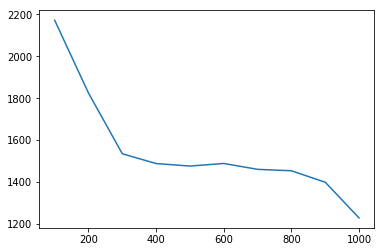

In [368]:
# Initialize a Neural Network (MLP) object
nn = neural_net_mlp(X_train, Y_train, n_hidden_nodes = 15, n_classes = 10, learning_rate = 0.5)
nn.train(n_epochs = 1000, n_prints = 10, showprint = 1, showplot = 1)

# Testing the Model

In [349]:
y_pred, _Z1, _A1 = nn.feed_forward(X_test)
cost = nn.loss_function(Y_test, y_pred)
print("Loss of test set: ", cost)

Loss of test set:  203.1239662326074


In [355]:
y_pred.shape

(10, 2500)

79th Predicted Value: 8


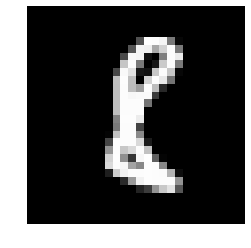

669th Predicted Value: 1


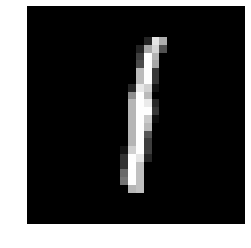

2314th Predicted Value: 8


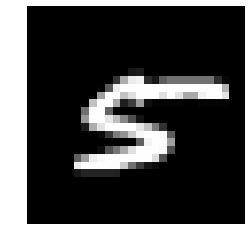

938th Predicted Value: 0


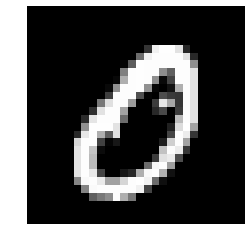

1414th Predicted Value: 5


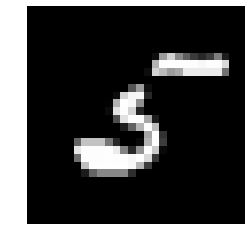

In [362]:
# Show results
def print_image_and_prediction(i, X, y_pred):
    predicted_result = np.argmax(y_pred[:,i])
    print("{}th Predicted Value: {}".format(i, predicted_result))
    example = X[:,i].reshape(28,28)
    plt.imshow(example, cmap = plt.cm.gray)
    plt.axis("off")
    plt.show()


for i in np.random.randint(X_test.shape[1], size = 5):
    print_image_and_prediction(i, X_test, y_pred)

# Conclusion

The model seems to have trained successfully, as seen by the cost being reduced as expected (steep decrease initially, with later a less steep slope). Additionally, the cost of the same model for the test set was similar or lower than the final cost of the training set, so we have not overfitted. 